# **Identificación de Imágenes Auténticas y Sintéticas : Abordando los Desafíos de las Imágenes Sintéticas en la Sociedad Actual**

**Contenido**
1. [Configuración del Entorno](#title1)
2. [Construcción del Conjunto de Datos](#title2)
3. [Creación del Modelo](#title3)

## Configuración del Entorno<a name="title1"></a>

In [1]:
import tensorflow as tf
print(tf.config.experimental.list_physical_devices("GPU"))
print(tf.__version__)
# Para limitar la memoria que usa la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar TensorFlow para que solo utilice la GPU si es necesario
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuración de GPU completada")
    except RuntimeError as e:
        print(e)
# Verifica que la GPU está disponible
print("¿GPU está disponible?:", tf.config.list_physical_devices('GPU'))
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import gc
import tensorflow as tf
from keras import backend as K

# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0
Configuración de GPU completada
¿GPU está disponible?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


0

In [2]:
# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()

105

In [2]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import csv
import warnings
# Suprimir las advertencias de Python
warnings.filterwarnings('ignore')

## Construcción del Conjunto de Datos y Preprocesandolos<a name="title2"></a>

Fuente: https://www.kaggle.com/datasets/kaustubhdhote/human-faces-dataset & https://www.kaggle.com/datasets/hamzaboulahia/hardfakevsrealfaces/code

In [3]:
# Verificar si el archivo existe y eliminarlo si es así
data_csv = './kaggle/working/dataset.csv'
if os.path.exists(data_csv):
    os.remove(data_csv)
    print(f"Archivo {data_csv} eliminado.")
else:
    print(f"Archivo {data_csv} no encontrado.")

data_csv = './kaggle/working/dataset.csv'
data_dir1 = './Data/All'

# Verificar la existencia del archivo CSV
if os.path.exists(data_csv):
    print('El archivo CSV ya existe.')
else:
    data_dirs = [data_dir1] 

    # Definir la ruta para el archivo CSV
    csv_file = 'dataset.csv'
    data_csv = csv_file

    # Definir el mapeo de clases
    class_mapping = {
        'fake': 'Fake',
        'real': 'Real',
        'Fake': 'Fake',
        'Real': 'Real',
    }

    # Abrir el archivo CSV en modo escritura
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['image', 'label'])  # Escribir la fila de encabezado

        # Iterar a través de los directorios en el conjunto de datos
        for data_dir in data_dirs:
            for root, dirs, files in os.walk(data_dir):
                for file in files:
                    if file.endswith('.jpg') or file.endswith('.png'):  # Ajustar las extensiones de archivo según sea necesario
                        # Obtener la ruta de la imagen
                        image_path = os.path.join(root, file)

                        # Extraer la etiqueta del nombre de la carpeta principal
                        label = os.path.basename(root)

                        # Aplicar el mapeo a la etiqueta
                        mapped_label = class_mapping.get(label, label)

                        # Escribir la ruta de la imagen y la etiqueta mapeada en el archivo CSV
                        writer.writerow([image_path, mapped_label])

    print(f"Archivo {csv_file} creado.")

Archivo ./kaggle/working/dataset.csv no encontrado.
Archivo dataset.csv creado.


In [4]:
data = pd.read_csv(data_csv)

height, width = 224, 224

def changeLabels(x):
    return labels[x]

labels = data.label.unique()
labels = {labels[i]: i for i in range(labels.size)}
y = data.label.apply(changeLabels)
y = to_categorical(y, len(labels))

X = np.empty((data.shape[0], height, width, 3), dtype=np.uint8)
for i in range(data.shape[0]):
    img_path = data.iloc[i]['image']  # Obtener la ruta del archivo
    img = load_img(img_path, target_size=(height, width))  # Cargar y redimensionar la imagen
    img_array = np.array(img)  # Convertir la imagen a un array numpy
    X[i] = img_array  # Agregar el array a X

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10919, 224, 224, 3)
(7643, 224, 224, 3)
(1638, 224, 224, 3)
(1638, 224, 224, 3)


# Modelo<a name="title3"></a>



In [5]:
tf.keras.backend.clear_session()

# Cargar el modelo MobileNetV3 Large
mobilenetv3 = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Aprendizaje por transferencia: Personalizar agregando nuevas capas sobre el modelo MobileNetV3 Large
x = Flatten()(mobilenetv3.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.45)(x)
output = Dense(len(labels), activation='softmax', kernel_regularizer=l2(0.001))(x)

# Crear el nuevo modelo
model_mobilenetv3 = Model(mobilenetv3.input, output)

# Compilar el modelo
model_mobilenetv3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_mobilenetv3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [6]:
# Entrenamiento del modelo
epochs = 15
history = model_mobilenetv3.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/15
239/239 [==============================] - 30s 92ms/step - loss: 0.7968 - accuracy: 0.9903 - val_loss: 4.2704 - val_accuracy: 0.9915
Epoch 2/15
239/239 [==============================] - 21s 87ms/step - loss: 0.3374 - accuracy: 0.9992 - val_loss: 134.3984 - val_accuracy: 0.8443
Epoch 3/15
239/239 [==============================] - 21s 87ms/step - loss: 0.2383 - accuracy: 0.9983 - val_loss: 1443.2904 - val_accuracy: 0.7405
Epoch 4/15
239/239 [==============================] - 21s 87ms/step - loss: 0.2065 - accuracy: 0.9983 - val_loss: 0.2229 - val_accuracy: 0.9994
Epoch 5/15
239/239 [==============================] - 21s 87ms/step - loss: 0.2006 - accuracy: 0.9987 - val_loss: 2583.3887 - val_accuracy: 0.5592
Epoch 6/15
239/239 [==============================] - 21s 87ms/step - loss: 0.9607 - accuracy: 0.9931 - val_loss: 34625368.0000 - val_accuracy: 0.5031
Epoch 7/15
239/239 [==============================] - 21s 87ms/step - loss: 0.5502 - accuracy: 0.9990 - val_loss: 745094.

52/52 [==============================] - 1s 20ms/step - loss: 0.0453 - accuracy: 0.9988
Pérdida en Prueba: 0.0453084297478199
Exactitud en Prueba: 0.9987789988517761
52/52 [==============================] - 1s 18ms/step
Reporte de Clasificación:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       802
        Real       1.00      1.00      1.00       836

    accuracy                           1.00      1638
   macro avg       1.00      1.00      1.00      1638
weighted avg       1.00      1.00      1.00      1638

Matriz de Confusión:
[[802   0]
 [  2 834]]


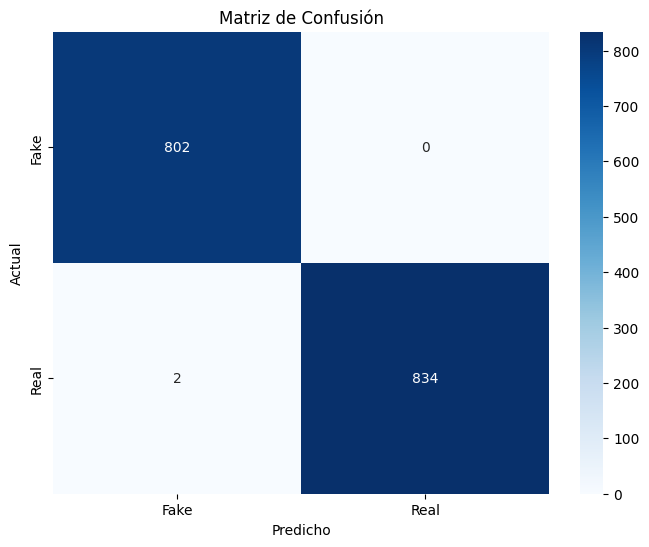

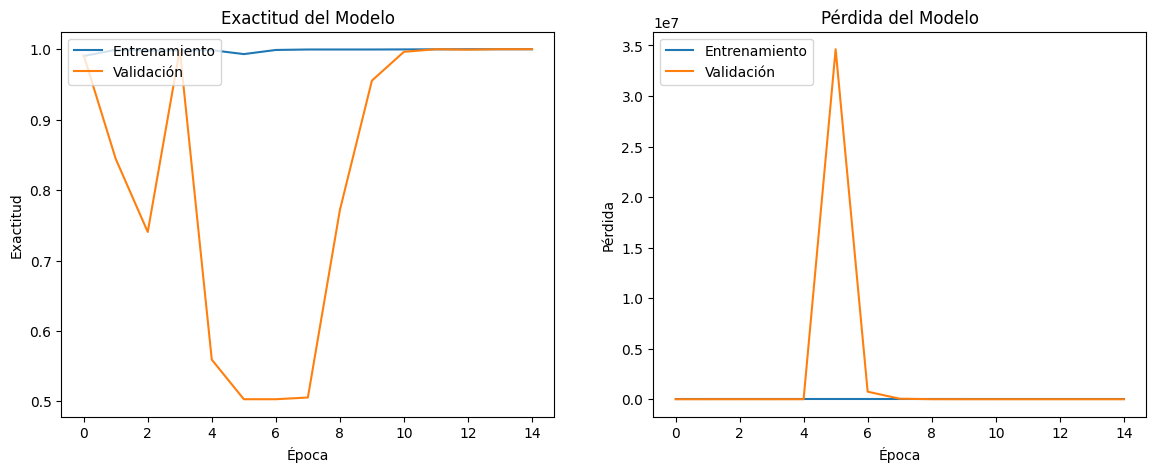

In [8]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model_mobilenetv3.evaluate(X_test, y_test)
print(f"Pérdida en Prueba: {test_loss}")
print(f"Exactitud en Prueba: {test_accuracy}")

# Generar predicciones
predictions = model_mobilenetv3.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Etiquetas verdaderas
true_classes = np.argmax(y_test, axis=1)
class_labels = list(labels.keys())

# Reporte de clasificación
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Reporte de Clasificación:")
print(report)

# Matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)
print("Matriz de Confusión:")
print(cm)

# Graficar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicho')
plt.title('Matriz de Confusión')
plt.show()

# Graficar historia de entrenamiento
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Exactitud del Modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(loc='upper left')

plt.show()